**Основная задача:**

Зарегистрируйтесь на платформе Kaggle и скачайте набор данных, и по образцу создайте нейронную сеть. Выведите матрицу ошибок и постарайтесь минимизировать их, подобрав параметры нейронной сети.

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN

from keras.models import Sequential
from keras.layers import Dense, Dropout

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

1. Загрузите [данные](https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv) с площадки Kaggle.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/carolinesofina/DS_sets/main/pima-indians-diabetes.csv')
df.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


2. Подготавливаем данные (приводим их к нужным типам данных, проводим базовое EDA, делаем  выводы, если возможно).

Для удобства присвоим колонкам названия вместо индексов

In [3]:
df.columns = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age',
              'target']

df.sample()

,preg,plas,pres,skin,test,mass,pedi,age,target
120,6,111,64,39,0,34.2,0.26,24,0


Посмотрим на общую картину данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    767 non-null    int64  
 1   plas    767 non-null    int64  
 2   pres    767 non-null    int64  
 3   skin    767 non-null    int64  
 4   test    767 non-null    int64  
 5   mass    767 non-null    float64
 6   pedi    767 non-null    float64
 7   age     767 non-null    int64  
 8   target  767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Очевидных пропусков в данных нет, но посмотрим подробнее.

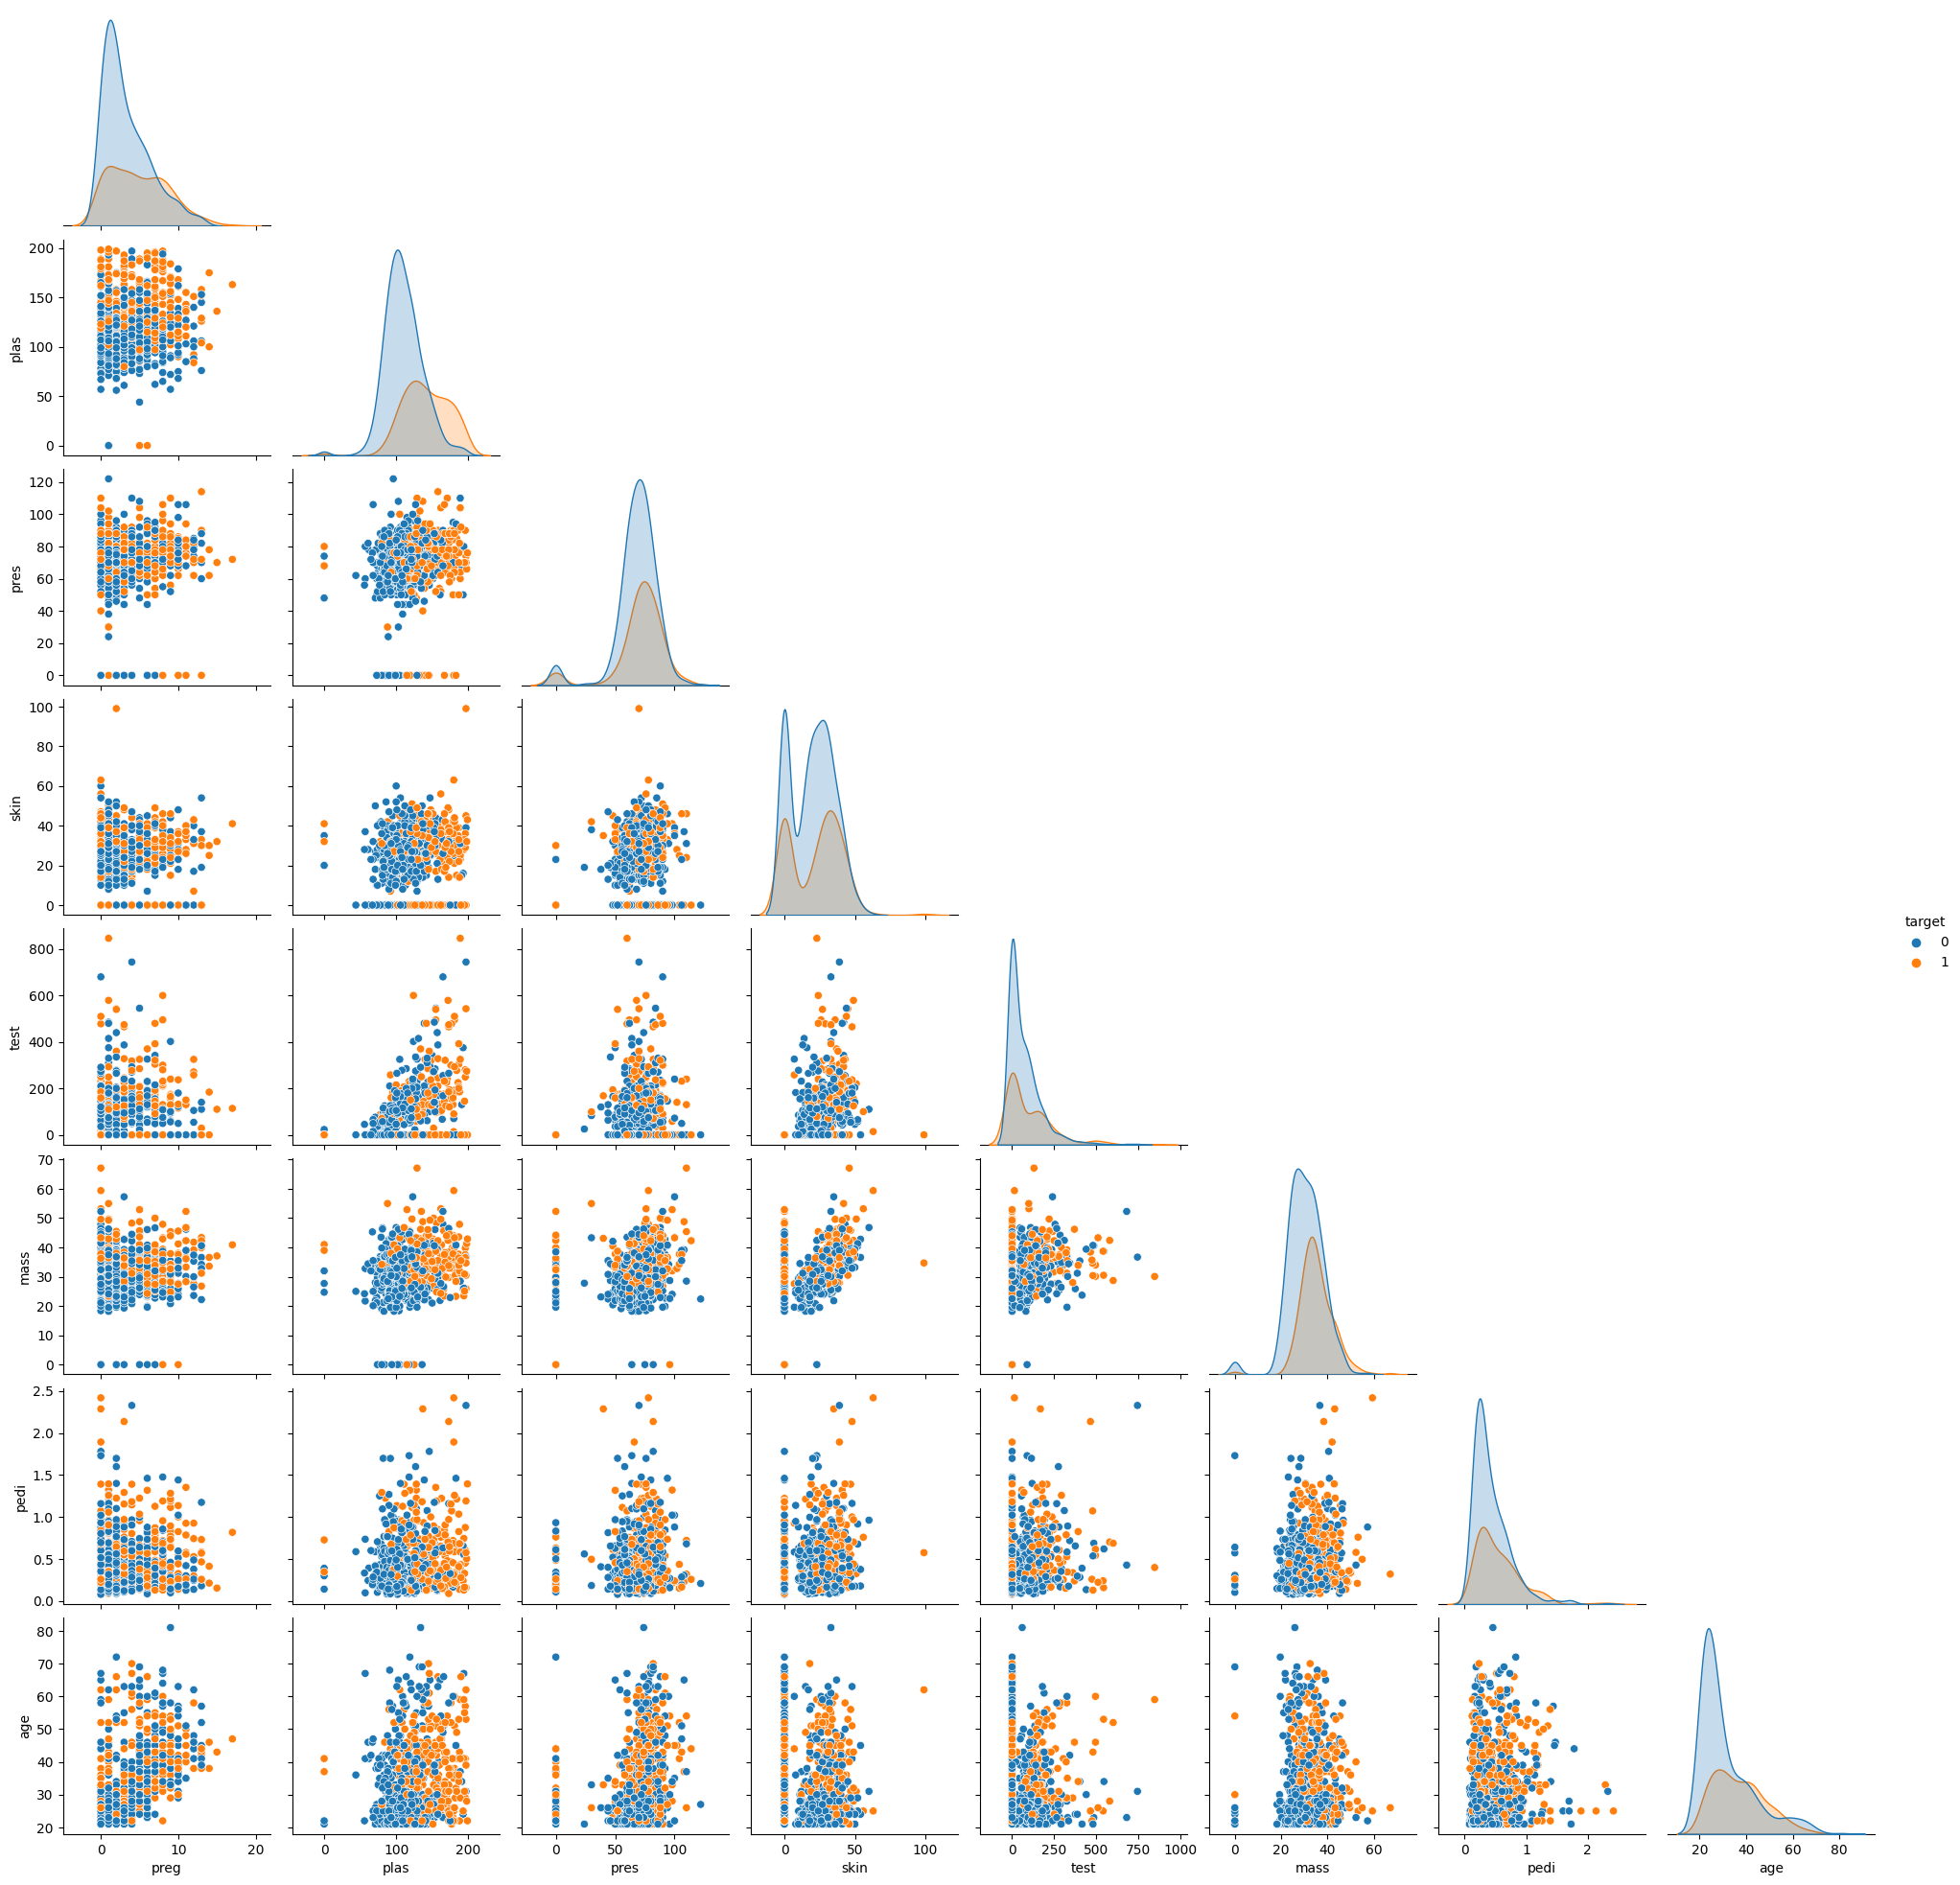

In [5]:
sns.pairplot(df, corner=True, hue='target');

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
preg,767.0,3.842243,3.370877,0.000,1.0000,3.000,6.000,17.00
plas,767.0,120.859192,31.978468,0.000,99.0000,117.000,140.000,199.00
pres,767.0,69.101695,19.368155,0.000,62.0000,72.000,80.000,122.00
skin,767.0,20.517601,15.954059,0.000,0.0000,23.000,32.000,99.00
test,767.0,79.903520,115.283105,0.000,0.0000,32.000,127.500,846.00
mass,767.0,31.990482,7.889091,0.000,27.3000,32.000,36.600,67.10
pedi,767.0,0.471674,0.331497,0.078,0.2435,0.371,0.625,2.42
age,767.0,33.219035,11.752296,21.000,24.0000,29.000,41.000,81.00
target,767.0,0.348110,0.476682,0.000,0.0000,0.000,1.000,1.00


В колонках с уровнем глюкозы, давлением, толщиной складки кожи, уровнем инсулина и ИМТ много 0. Эти показатели не могут быть равны 0 - вероятно, это неочевидные пропуски в данных и их стоит заполнить медианным значением. Прежде чем сделать это, посмотрим на матрицу корреляций.

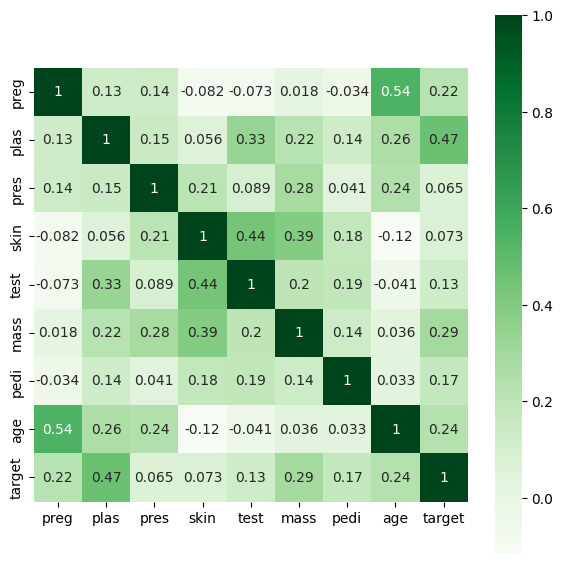

In [7]:
tmp = df.corr()

plt.figure(figsize=(7,7))
sns.heatmap(tmp, annot=True, cmap='Greens')
plt.imshow(tmp)
plt.show()

Сильных корреляций между признаками нет, самая сильная связь - между возрастом и количеством беременностей, что вполне логично. Избавимся от ложных нулей в колонках plas, pres,	skin, test, mass, заменив их на медианное значение.

In [8]:
for col in df[['plas', 'pres', 'skin', 'test', 'mass']].columns:
    df[col] = df[col].apply(lambda x: df['pres'].median() if x == 0 else x)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
preg,767.0,3.842243,3.370877,0.000,1.0000,3.000,6.000,17.00
plas,767.0,121.328553,30.702421,44.000,99.0000,117.000,140.000,199.00
pres,767.0,72.387223,12.104527,24.000,64.0000,72.000,80.000,122.00
skin,767.0,41.826597,21.460570,7.000,25.0000,35.000,72.000,99.00
test,767.0,114.917862,94.784336,14.000,72.0000,72.000,127.500,846.00
mass,767.0,33.023077,8.334347,18.200,27.5000,32.400,36.850,72.00
pedi,767.0,0.471674,0.331497,0.078,0.2435,0.371,0.625,2.42
age,767.0,33.219035,11.752296,21.000,24.0000,29.000,41.000,81.00
target,767.0,0.348110,0.476682,0.000,0.0000,0.000,1.000,1.00


От ложных пропусков мы избавились. Проверим типы данных.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    767 non-null    int64  
 1   plas    767 non-null    float64
 2   pres    767 non-null    float64
 3   skin    767 non-null    float64
 4   test    767 non-null    float64
 5   mass    767 non-null    float64
 6   pedi    767 non-null    float64
 7   age     767 non-null    int64  
 8   target  767 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


Колонки preg и age необходимо привести к типу float64. Для удобства сразу отделим целевое значение от признаков.

In [11]:
features = df.drop(['target'], axis=1)
target = df['target']

In [12]:
for col in features.select_dtypes(include=['int64']):
    features[col] = features[col].astype(float)

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    767 non-null    float64
 1   plas    767 non-null    float64
 2   pres    767 non-null    float64
 3   skin    767 non-null    float64
 4   test    767 non-null    float64
 5   mass    767 non-null    float64
 6   pedi    767 non-null    float64
 7   age     767 non-null    float64
dtypes: float64(8)
memory usage: 48.1 KB


Проверим баланс классов целевого признака

In [13]:
target.value_counts()

target
0    500
1    267
Name: count, dtype: int64

Есть легкий дисбаланс, соотношение классов ~1:2. Попробуем устранить его с помощью алгоритма ADASYN.

In [14]:
ada = ADASYN(random_state=5)
features_ada, target_ada = ada.fit_resample(features, target)

In [15]:
target_ada.value_counts()

target
0    500
1    466
Name: count, dtype: int64

Дисбаланс успешно устранен.

3. Создаем тренировочную и валидационную выборки. Так как данных мало, возьмем небольщую тестовую выборку - 10%.

In [16]:
features_train, features_test, target_train, target_test =\
    train_test_split(features_ada, target_ada, random_state=0,
                     shuffle=True, test_size=0.1)

4. Масштабируем данные известными вам методами из библиотеки Scikit-learn.

In [17]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

5. Создайте функцию, при вызове которой будет собираться и компилироваться (model.compile) архитектура модели. Функция должна возвращать собранную архитектуру. Параметры слоев и их количество вы выбираете сами, стараясь добиться наилучшего качества.

In [18]:
def custom_model():
    # Создаём полносвязную сеть
    model = Sequential()

    # Добавляем слои, указываем входной размер 8, соответствующий размеру входных данных
    model.add(Dense(256, input_dim=features.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=['accuracy'])

    print(model.summary())

    return model

6. Обучите модель.

In [22]:
model = custom_model()
my_model = model.fit(features_train, target_train, batch_size=8, epochs=30,
                     validation_split=0.2, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               2304      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params: 3650

_________________________________________________________________
None
Epoch 1/30
87/87 [==============================] - 2s 6ms/step - loss: 0.6595 - accuracy: 0.6460 - val_loss: 0.6348 - val_accuracy: 0.6839
Epoch 2/30
87/87 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.7237 - val_loss: 0.6170 - val_accuracy: 0.6839
Epoch 3/30
87/87 [==============================] - 0s 4ms/step - loss: 0.5859 - accuracy: 0.7496 - val_loss: 0.6049 - val_accuracy: 0.6897
Epoch 4/30
87/87 [==============================] - 0s 4ms/step - loss: 0.5798 - accuracy: 0.7410 - val_loss: 0.5952 - val_accuracy: 0.7184
Epoch 5/30
87/87 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.7381 - val_loss: 0.5885 - val_accuracy: 0.7299
Epoch 6/30
87/87 [==============================] - 0s 4ms/step - loss: 0.5589 - accuracy: 0.7540 - val_loss: 0.5818 - val_accuracy: 0.7299
Epoch 7/30
87/87 [==============================] - 0s 4ms/step - loss: 0.5558 - accuracy

7. Оцените качество модели по выбранной вами метрике (выбор метрики должен быть обоснован).

В качестве метрики выберем точность - очень простую и легкую в интерпретации метрику для задач классифифкации.

In [24]:
target_pred = [1 if i > 0.5 else 0 for i in model.predict(features_test)]
print(f'Accuracy модели на тестовой выборке: {round(accuracy_score(target_test, target_pred), 4)}')

4/4 [==============================] - 0s 3ms/step
Accuracy модели на тестовой выборке: 0.8351


Точность на тестовой выборке приемлемая - 0.8041 против 0.8223 на обучающей. Далее попробуем ее улучшить с помощью перебора параметров.

8. Постройте графики точности и графики ошибки в зависимости от количества эпох для тренировочной выборки и для валидационной.

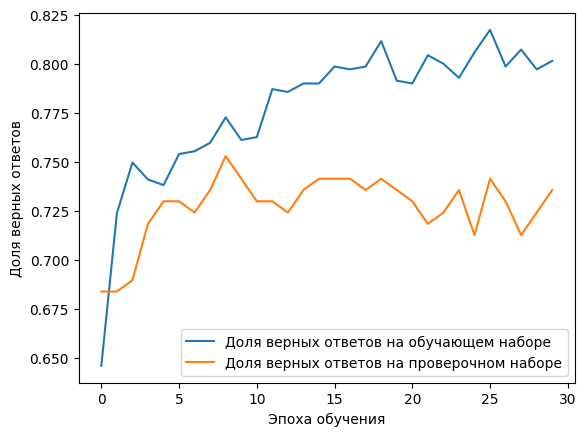

In [25]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

9. Постройте матрицу ошибок для валидационной выборки.

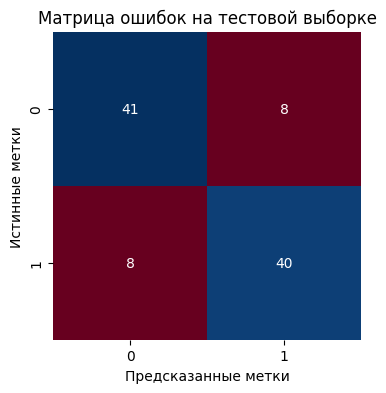

In [26]:
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(target_test, target_pred),
            square=True, annot=True, cmap='RdBu', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок на тестовой выборке')
plt.show()

**ЗАДАНИЕ ПРО:**

Оптимизируйте параметры модели в автоматическом режиме. Можно использовать алгоритмы оптимизации типа GridSearch, но не сильно увлекаясь — иначе расчёт может быть излишне долог.

1. Поместите вашу модель в оболочку KerasClassifier.

In [27]:
model = KerasClassifier(build_fn=custom_model, batch_size=8,
                        epochs=10, validation_split=0.1, verbose=0)

2. Подберите оптимальные параметры для модели с помощью GridSearchCV или RandomizedSearchCV.

In [28]:
params = [
    {'batch_size': [8, 16]}, 
    {'epochs': [15, 25, 50]},
    {'validation_split': [0.1, 0.2, 0.3]}
]

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring='accuracy')
grid_search.fit(X=features_train, y=target_train)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               2304      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params: 3650

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               2304      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                1290      
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               2304      
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                1290      
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               2304      
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                1290      
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               2304      
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                1290      
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               2304      
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 10)                1290      
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 256)               2304      
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 10)                1290      
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               2304      
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 10)                1290      
                                                                 
 dense_39 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params:

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               2304      
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 10)                1290      
                                                                 
 dense_43 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 256)               2304      
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 10)                1290      
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               2304      
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 10)                1290      
                                                                 
 dense_51 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               2304      
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 128)               32896     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_54 (Dense)            (None, 10)                1290      
                                                                 
 dense_55 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               2304      
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 128)               32896     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 10)                1290      
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 256)               2304      
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_61 (Dense)            (None, 128)               32896     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 10)                1290      
                                                                 
 dense_63 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 256)               2304      
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_65 (Dense)            (None, 128)               32896     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_66 (Dense)            (None, 10)                1290      
                                                                 
 dense_67 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 256)               2304      
                                                                 
 dropout_34 (Dropout)        (None, 256)               0         
                                                                 
 dense_69 (Dense)            (None, 128)               32896     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 10)                1290      
                                                                 
 dense_71 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               2304      
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_73 (Dense)            (None, 128)               32896     
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 10)                1290      
                                                                 
 dense_75 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 256)               2304      
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_77 (Dense)            (None, 128)               32896     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_78 (Dense)            (None, 10)                1290      
                                                                 
 dense_79 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 256)               2304      
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               32896     
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 10)                1290      
                                                                 
 dense_83 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 256)               2304      
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               32896     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 10)                1290      
                                                                 
 dense_87 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None


c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 256)               2304      
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_89 (Dense)            (None, 128)               32896     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_90 (Dense)            (None, 10)                1290      
                                                                 
 dense_91 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params: 365

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 256)               2304      
                                                                 
 dropout_48 (Dropout)        (None, 256)               0         
                                                                 
 dense_97 (Dense)            (None, 128)               32896     
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_98 (Dense)            (None, 10)                1290      
                                                                 
 dense_99 (Dense)            (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 256)               2304      
                                                                 
 dropout_50 (Dropout)        (None, 256)               0         
                                                                 
 dense_101 (Dense)           (None, 128)               32896     
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_102 (Dense)           (None, 10)                1290      
                                                                 
 dense_103 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 256)               2304      
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_105 (Dense)           (None, 128)               32896     
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_106 (Dense)           (None, 10)                1290      
                                                                 
 dense_107 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 256)               2304      
                                                                 
 dropout_54 (Dropout)        (None, 256)               0         
                                                                 
 dense_109 (Dense)           (None, 128)               32896     
                                                                 
 dropout_55 (Dropout)        (None, 128)               0         
                                                                 
 dense_110 (Dense)           (None, 10)                1290      
                                                                 
 dense_111 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 256)               2304      
                                                                 
 dropout_56 (Dropout)        (None, 256)               0         
                                                                 
 dense_113 (Dense)           (None, 128)               32896     
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_114 (Dense)           (None, 10)                1290      
                                                                 
 dense_115 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 256)               2304      
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_117 (Dense)           (None, 128)               32896     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_118 (Dense)           (None, 10)                1290      
                                                                 
 dense_119 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 256)               2304      
                                                                 
 dropout_60 (Dropout)        (None, 256)               0         
                                                                 
 dense_121 (Dense)           (None, 128)               32896     
                                                                 
 dropout_61 (Dropout)        (None, 128)               0         
                                                                 
 dense_122 (Dense)           (None, 10)                1290      
                                                                 
 dense_123 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 256)               2304      
                                                                 
 dropout_62 (Dropout)        (None, 256)               0         
                                                                 
 dense_125 (Dense)           (None, 128)               32896     
                                                                 
 dropout_63 (Dropout)        (None, 128)               0         
                                                                 
 dense_126 (Dense)           (None, 10)                1290      
                                                                 
 dense_127 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 256)               2304      
                                                                 
 dropout_64 (Dropout)        (None, 256)               0         
                                                                 
 dense_129 (Dense)           (None, 128)               32896     
                                                                 
 dropout_65 (Dropout)        (None, 128)               0         
                                                                 
 dense_130 (Dense)           (None, 10)                1290      
                                                                 
 dense_131 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 256)               2304      
                                                                 
 dropout_66 (Dropout)        (None, 256)               0         
                                                                 
 dense_133 (Dense)           (None, 128)               32896     
                                                                 
 dropout_67 (Dropout)        (None, 128)               0         
                                                                 
 dense_134 (Dense)           (None, 10)                1290      
                                                                 
 dense_135 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 256)               2304      
                                                                 
 dropout_68 (Dropout)        (None, 256)               0         
                                                                 
 dense_137 (Dense)           (None, 128)               32896     
                                                                 
 dropout_69 (Dropout)        (None, 128)               0         
                                                                 
 dense_138 (Dense)           (None, 10)                1290      
                                                                 
 dense_139 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 256)               2304      
                                                                 
 dropout_70 (Dropout)        (None, 256)               0         
                                                                 
 dense_141 (Dense)           (None, 128)               32896     
                                                                 
 dropout_71 (Dropout)        (None, 128)               0         
                                                                 
 dense_142 (Dense)           (None, 10)                1290      
                                                                 
 dense_143 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 256)               2304      
                                                                 
 dropout_72 (Dropout)        (None, 256)               0         
                                                                 
 dense_145 (Dense)           (None, 128)               32896     
                                                                 
 dropout_73 (Dropout)        (None, 128)               0         
                                                                 
 dense_146 (Dense)           (None, 10)                1290      
                                                                 
 dense_147 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 256)               2304      
                                                                 
 dropout_74 (Dropout)        (None, 256)               0         
                                                                 
 dense_149 (Dense)           (None, 128)               32896     
                                                                 
 dropout_75 (Dropout)        (None, 128)               0         
                                                                 
 dense_150 (Dense)           (None, 10)                1290      
                                                                 
 dense_151 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 256)               2304      
                                                                 
 dropout_76 (Dropout)        (None, 256)               0         
                                                                 
 dense_153 (Dense)           (None, 128)               32896     
                                                                 
 dropout_77 (Dropout)        (None, 128)               0         
                                                                 
 dense_154 (Dense)           (None, 10)                1290      
                                                                 
 dense_155 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 256)               2304      
                                                                 
 dropout_78 (Dropout)        (None, 256)               0         
                                                                 
 dense_157 (Dense)           (None, 128)               32896     
                                                                 
 dropout_79 (Dropout)        (None, 128)               0         
                                                                 
 dense_158 (Dense)           (None, 10)                1290      
                                                                 
 dense_159 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 dense_160 (Dense)           (None, 256)               2304      
                                                                 
 dropout_80 (Dropout)        (None, 256)               0         
                                                                 
 dense_161 (Dense)           (None, 128)               32896     
                                                                 
 dropout_81 (Dropout)        (None, 128)               0         
                                                                 
 dense_162 (Dense)           (None, 10)                1290      
                                                                 
 dense_163 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params: 36501 (142.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_41"
__________

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 256)               2304      
                                                                 
 dropout_84 (Dropout)        (None, 256)               0         
                                                                 
 dense_169 (Dense)           (None, 128)               32896     
                                                                 
 dropout_85 (Dropout)        (None, 128)               0         
                                                                 
 dense_170 (Dense)           (None, 10)                1290      
                                                                 
 dense_171 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 256)               2304      
                                                                 
 dropout_86 (Dropout)        (None, 256)               0         
                                                                 
 dense_173 (Dense)           (None, 128)               32896     
                                                                 
 dropout_87 (Dropout)        (None, 128)               0         
                                                                 
 dense_174 (Dense)           (None, 10)                1290      
                                                                 
 dense_175 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_176 (Dense)           (None, 256)               2304      
                                                                 
 dropout_88 (Dropout)        (None, 256)               0         
                                                                 
 dense_177 (Dense)           (None, 128)               32896     
                                                                 
 dropout_89 (Dropout)        (None, 128)               0         
                                                                 
 dense_178 (Dense)           (None, 10)                1290      
                                                                 
 dense_179 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 256)               2304      
                                                                 
 dropout_90 (Dropout)        (None, 256)               0         
                                                                 
 dense_181 (Dense)           (None, 128)               32896     
                                                                 
 dropout_91 (Dropout)        (None, 128)               0         
                                                                 
 dense_182 (Dense)           (None, 10)                1290      
                                                                 
 dense_183 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 256)               2304      
                                                                 
 dropout_92 (Dropout)        (None, 256)               0         
                                                                 
 dense_185 (Dense)           (None, 128)               32896     
                                                                 
 dropout_93 (Dropout)        (None, 128)               0         
                                                                 
 dense_186 (Dense)           (None, 10)                1290      
                                                                 
 dense_187 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 256)               2304      
                                                                 
 dropout_94 (Dropout)        (None, 256)               0         
                                                                 
 dense_189 (Dense)           (None, 128)               32896     
                                                                 
 dropout_95 (Dropout)        (None, 128)               0         
                                                                 
 dense_190 (Dense)           (None, 10)                1290      
                                                                 
 dense_191 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 256)               2304      
                                                                 
 dropout_96 (Dropout)        (None, 256)               0         
                                                                 
 dense_193 (Dense)           (None, 128)               32896     
                                                                 
 dropout_97 (Dropout)        (None, 128)               0         
                                                                 
 dense_194 (Dense)           (None, 10)                1290      
                                                                 
 dense_195 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 256)               2304      
                                                                 
 dropout_98 (Dropout)        (None, 256)               0         
                                                                 
 dense_197 (Dense)           (None, 128)               32896     
                                                                 
 dropout_99 (Dropout)        (None, 128)               0         
                                                                 
 dense_198 (Dense)           (None, 10)                1290      
                                                                 
 dense_199 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 256)               2304      
                                                                 
 dropout_100 (Dropout)       (None, 256)               0         
                                                                 
 dense_201 (Dense)           (None, 128)               32896     
                                                                 
 dropout_101 (Dropout)       (None, 128)               0         
                                                                 
 dense_202 (Dense)           (None, 10)                1290      
                                                                 
 dense_203 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 256)               2304      
                                                                 
 dropout_102 (Dropout)       (None, 256)               0         
                                                                 
 dense_205 (Dense)           (None, 128)               32896     
                                                                 
 dropout_103 (Dropout)       (None, 128)               0         
                                                                 
 dense_206 (Dense)           (None, 10)                1290      
                                                                 
 dense_207 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 256)               2304      
                                                                 
 dropout_104 (Dropout)       (None, 256)               0         
                                                                 
 dense_209 (Dense)           (None, 128)               32896     
                                                                 
 dropout_105 (Dropout)       (None, 128)               0         
                                                                 
 dense_210 (Dense)           (None, 10)                1290      
                                                                 
 dense_211 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_212 (Dense)           (None, 256)               2304      
                                                                 
 dropout_106 (Dropout)       (None, 256)               0         
                                                                 
 dense_213 (Dense)           (None, 128)               32896     
                                                                 
 dropout_107 (Dropout)       (None, 128)               0         
                                                                 
 dense_214 (Dense)           (None, 10)                1290      
                                                                 
 dense_215 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 256)               2304      
                                                                 
 dropout_108 (Dropout)       (None, 256)               0         
                                                                 
 dense_217 (Dense)           (None, 128)               32896     
                                                                 
 dropout_109 (Dropout)       (None, 128)               0         
                                                                 
 dense_218 (Dense)           (None, 10)                1290      
                                                                 
 dense_219 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 256)               2304      
                                                                 
 dropout_110 (Dropout)       (None, 256)               0         
                                                                 
 dense_221 (Dense)           (None, 128)               32896     
                                                                 
 dropout_111 (Dropout)       (None, 128)               0         
                                                                 
 dense_222 (Dense)           (None, 10)                1290      
                                                                 
 dense_223 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 256)               2304      
                                                                 
 dropout_112 (Dropout)       (None, 256)               0         
                                                                 
 dense_225 (Dense)           (None, 128)               32896     
                                                                 
 dropout_113 (Dropout)       (None, 128)               0         
                                                                 
 dense_226 (Dense)           (None, 10)                1290      
                                                                 
 dense_227 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 256)               2304      
                                                                 
 dropout_114 (Dropout)       (None, 256)               0         
                                                                 
 dense_229 (Dense)           (None, 128)               32896     
                                                                 
 dropout_115 (Dropout)       (None, 128)               0         
                                                                 
 dense_230 (Dense)           (None, 10)                1290      
                                                                 
 dense_231 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_232 (Dense)           (None, 256)               2304      
                                                                 
 dropout_116 (Dropout)       (None, 256)               0         
                                                                 
 dense_233 (Dense)           (None, 128)               32896     
                                                                 
 dropout_117 (Dropout)       (None, 128)               0         
                                                                 
 dense_234 (Dense)           (None, 10)                1290      
                                                                 
 dense_235 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_236 (Dense)           (None, 256)               2304      
                                                                 
 dropout_118 (Dropout)       (None, 256)               0         
                                                                 
 dense_237 (Dense)           (None, 128)               32896     
                                                                 
 dropout_119 (Dropout)       (None, 128)               0         
                                                                 
 dense_238 (Dense)           (None, 10)                1290      
                                                                 
 dense_239 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 256)               2304      
                                                                 
 dropout_120 (Dropout)       (None, 256)               0         
                                                                 
 dense_241 (Dense)           (None, 128)               32896     
                                                                 
 dropout_121 (Dropout)       (None, 128)               0         
                                                                 
 dense_242 (Dense)           (None, 10)                1290      
                                                                 
 dense_243 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_244 (Dense)           (None, 256)               2304      
                                                                 
 dropout_122 (Dropout)       (None, 256)               0         
                                                                 
 dense_245 (Dense)           (None, 128)               32896     
                                                                 
 dropout_123 (Dropout)       (None, 128)               0         
                                                                 
 dense_246 (Dense)           (None, 10)                1290      
                                                                 
 dense_247 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_248 (Dense)           (None, 256)               2304      
                                                                 
 dropout_124 (Dropout)       (None, 256)               0         
                                                                 
 dense_249 (Dense)           (None, 128)               32896     
                                                                 
 dropout_125 (Dropout)       (None, 128)               0         
                                                                 
 dense_250 (Dense)           (None, 10)                1290      
                                                                 
 dense_251 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 256)               2304      
                                                                 
 dropout_126 (Dropout)       (None, 256)               0         
                                                                 
 dense_253 (Dense)           (None, 128)               32896     
                                                                 
 dropout_127 (Dropout)       (None, 128)               0         
                                                                 
 dense_254 (Dense)           (None, 10)                1290      
                                                                 
 dense_255 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 256)               2304      
                                                                 
 dropout_128 (Dropout)       (None, 256)               0         
                                                                 
 dense_257 (Dense)           (None, 128)               32896     
                                                                 
 dropout_129 (Dropout)       (None, 128)               0         
                                                                 
 dense_258 (Dense)           (None, 10)                1290      
                                                                 
 dense_259 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 256)               2304      
                                                                 
 dropout_130 (Dropout)       (None, 256)               0         
                                                                 
 dense_261 (Dense)           (None, 128)               32896     
                                                                 
 dropout_131 (Dropout)       (None, 128)               0         
                                                                 
 dense_262 (Dense)           (None, 10)                1290      
                                                                 
 dense_263 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 256)               2304      
                                                                 
 dropout_132 (Dropout)       (None, 256)               0         
                                                                 
 dense_265 (Dense)           (None, 128)               32896     
                                                                 
 dropout_133 (Dropout)       (None, 128)               0         
                                                                 
 dense_266 (Dense)           (None, 10)                1290      
                                                                 
 dense_267 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_268 (Dense)           (None, 256)               2304      
                                                                 
 dropout_134 (Dropout)       (None, 256)               0         
                                                                 
 dense_269 (Dense)           (None, 128)               32896     
                                                                 
 dropout_135 (Dropout)       (None, 128)               0         
                                                                 
 dense_270 (Dense)           (None, 10)                1290      
                                                                 
 dense_271 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_272 (Dense)           (None, 256)               2304      
                                                                 
 dropout_136 (Dropout)       (None, 256)               0         
                                                                 
 dense_273 (Dense)           (None, 128)               32896     
                                                                 
 dropout_137 (Dropout)       (None, 128)               0         
                                                                 
 dense_274 (Dense)           (None, 10)                1290      
                                                                 
 dense_275 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 256)               2304      
                                                                 
 dropout_138 (Dropout)       (None, 256)               0         
                                                                 
 dense_277 (Dense)           (None, 128)               32896     
                                                                 
 dropout_139 (Dropout)       (None, 128)               0         
                                                                 
 dense_278 (Dense)           (None, 10)                1290      
                                                                 
 dense_279 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_280 (Dense)           (None, 256)               2304      
                                                                 
 dropout_140 (Dropout)       (None, 256)               0         
                                                                 
 dense_281 (Dense)           (None, 128)               32896     
                                                                 
 dropout_141 (Dropout)       (None, 128)               0         
                                                                 
 dense_282 (Dense)           (None, 10)                1290      
                                                                 
 dense_283 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_284 (Dense)           (None, 256)               2304      
                                                                 
 dropout_142 (Dropout)       (None, 256)               0         
                                                                 
 dense_285 (Dense)           (None, 128)               32896     
                                                                 
 dropout_143 (Dropout)       (None, 128)               0         
                                                                 
 dense_286 (Dense)           (None, 10)                1290      
                                                                 
 dense_287 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 256)               2304      
                                                                 
 dropout_144 (Dropout)       (None, 256)               0         
                                                                 
 dense_289 (Dense)           (None, 128)               32896     
                                                                 
 dropout_145 (Dropout)       (None, 128)               0         
                                                                 
 dense_290 (Dense)           (None, 10)                1290      
                                                                 
 dense_291 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_292 (Dense)           (None, 256)               2304      
                                                                 
 dropout_146 (Dropout)       (None, 256)               0         
                                                                 
 dense_293 (Dense)           (None, 128)               32896     
                                                                 
 dropout_147 (Dropout)       (None, 128)               0         
                                                                 
 dense_294 (Dense)           (None, 10)                1290      
                                                                 
 dense_295 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 256)               2304      
                                                                 
 dropout_148 (Dropout)       (None, 256)               0         
                                                                 
 dense_297 (Dense)           (None, 128)               32896     
                                                                 
 dropout_149 (Dropout)       (None, 128)               0         
                                                                 
 dense_298 (Dense)           (None, 10)                1290      
                                                                 
 dense_299 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, 256)               2304      
                                                                 
 dropout_150 (Dropout)       (None, 256)               0         
                                                                 
 dense_301 (Dense)           (None, 128)               32896     
                                                                 
 dropout_151 (Dropout)       (None, 128)               0         
                                                                 
 dense_302 (Dense)           (None, 10)                1290      
                                                                 
 dense_303 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_304 (Dense)           (None, 256)               2304      
                                                                 
 dropout_152 (Dropout)       (None, 256)               0         
                                                                 
 dense_305 (Dense)           (None, 128)               32896     
                                                                 
 dropout_153 (Dropout)       (None, 128)               0         
                                                                 
 dense_306 (Dense)           (None, 10)                1290      
                                                                 
 dense_307 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_308 (Dense)           (None, 256)               2304      
                                                                 
 dropout_154 (Dropout)       (None, 256)               0         
                                                                 
 dense_309 (Dense)           (None, 128)               32896     
                                                                 
 dropout_155 (Dropout)       (None, 128)               0         
                                                                 
 dense_310 (Dense)           (None, 10)                1290      
                                                                 
 dense_311 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_312 (Dense)           (None, 256)               2304      
                                                                 
 dropout_156 (Dropout)       (None, 256)               0         
                                                                 
 dense_313 (Dense)           (None, 128)               32896     
                                                                 
 dropout_157 (Dropout)       (None, 128)               0         
                                                                 
 dense_314 (Dense)           (None, 10)                1290      
                                                                 
 dense_315 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_316 (Dense)           (None, 256)               2304      
                                                                 
 dropout_158 (Dropout)       (None, 256)               0         
                                                                 
 dense_317 (Dense)           (None, 128)               32896     
                                                                 
 dropout_159 (Dropout)       (None, 128)               0         
                                                                 
 dense_318 (Dense)           (None, 10)                1290      
                                                                 
 dense_319 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_320 (Dense)           (None, 256)               2304      
                                                                 
 dropout_160 (Dropout)       (None, 256)               0         
                                                                 
 dense_321 (Dense)           (None, 128)               32896     
                                                                 
 dropout_161 (Dropout)       (None, 128)               0         
                                                                 
 dense_322 (Dense)           (None, 10)                1290      
                                                                 
 dense_323 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_324 (Dense)           (None, 256)               2304      
                                                                 
 dropout_162 (Dropout)       (None, 256)               0         
                                                                 
 dense_325 (Dense)           (None, 128)               32896     
                                                                 
 dropout_163 (Dropout)       (None, 128)               0         
                                                                 
 dense_326 (Dense)           (None, 10)                1290      
                                                                 
 dense_327 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_328 (Dense)           (None, 256)               2304      
                                                                 
 dropout_164 (Dropout)       (None, 256)               0         
                                                                 
 dense_329 (Dense)           (None, 128)               32896     
                                                                 
 dropout_165 (Dropout)       (None, 128)               0         
                                                                 
 dense_330 (Dense)           (None, 10)                1290      
                                                                 
 dense_331 (Dense)           (None, 1)                 11        
                                                                 
Total params: 36501 (142.58 KB)
Trainable params

c:\Users\carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None


GridSearchCV(cv=10,
             estimator=KerasClassifier(batch_size=8, build_fn=<function custom_model at 0x000001F8E8BA3920>, epochs=10, validation_split=0.1, verbose=0),
             param_grid=[{'batch_size': [8, 16]}, {'epochs': [15, 25, 50]},
                         {'validation_split': [0.1, 0.2, 0.3]}],
             scoring='accuracy')

In [29]:
grid_search.best_estimator_

KerasClassifier(
	model=None
	build_fn=<function custom_model at 0x000001F8E8BA3920>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=8
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=25
	class_weight=None
)

In [30]:
grid_search.best_score_

0.7639802191927293


3. Посчитайте метрику с наилучшими параметрами, напишите наилучшие параметры для модели в выводе.

In [32]:
target_pred = [1 if i > 0.5 else 0 for i in grid_search.predict_proba(features_test)[:, 1]]
print(f'Качество модели на тестовой выборке c лучшей моделью: {round(accuracy_score(target_test, target_pred), 4)}')

Качество модели на тестовой выборке c лучшей моделью: 0.8351


С помощью перебора параметров удалось немного повысить точность модели - с 0.8041 до 0.8144

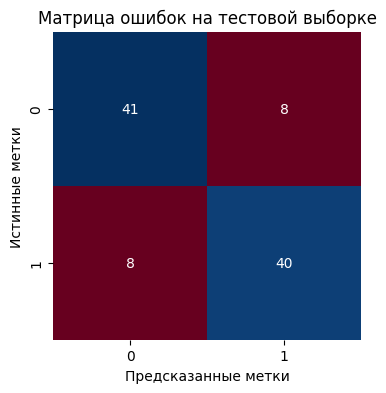

In [33]:
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(target_test, target_pred),
            square=True, annot=True, cmap='RdBu', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок на тестовой выборке')
plt.show()

Вывод: лучший результат с показателем метрики точности равным 0.8144 на тестовой выборке показала модель со следующими параметрами:

batch_size: 8, 
epochs: 50,
validation_split: 0.1.